# NYC Property Sales

About this Dataset
Context
This dataset is a record of every building or building unit (apartment, etc.) sold in the New York City property market over 
a 12-month period.

Content
This dataset contains the location, address, type, sale price, and sale date of building units sold. A reference on the 
trickier fields:

BOROUGH: A digit code for the borough the property is located in; in order these are Manhattan (1), Bronx (2), Brooklyn (3),
Queens (4), and Staten Island (5).
BLOCK; LOT: The combination of borough, block, and lot forms a unique key for property in New York City. Commonly called a BBL.
BUILDING CLASS AT PRESENT and BUILDING CLASS AT TIME OF SALE: The type of building at various points in time. See the glossary
linked to below.
For further reference on individual fields see the Glossary of Terms. For the building classification codes see 
the Building Classifications Glossary.

Note that because this is a financial transaction dataset, there are some points that need to be kept in mind:

Many sales occur with a nonsensically small dollar amount: $0 most commonly. These sales are actually 
transfers of deeds between parties: for example, parents transferring ownership to their home to a child after 
moving out for retirement.

This dataset uses the financial definition of a building/building unit, for tax purposes. In case a single entity
owns the building in question, a sale covers the value of the entire building. In case a building is owned piecemeal 
by its residents (a condominium), a sale refers to a single apartment (or group of apartments) owned by some individual.

Acknowledgements
This dataset is a concatenated and slightly cleaned-up version of the New York City Department of Finance's 
Rolling Sales dataset.

Inspiration
What can you discover about New York City real estate by looking at a year's worth of raw transaction records? 
Can you spot trends in the market, or build a model that predicts sale value in the future?

Inspired from https://www.kaggle.com/sahilrider/learn-regression-nyc/notebook


## 1. Importing and cleaning

In [2]:
# Import relevant modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import datetime as dt

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from scipy import stats

In [3]:
df = pd.read_csv("nyc-rolling-sales.csv")
df.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [4]:
# Deleting column as it is empty
del df["EASE-MENT"]
del df["APARTMENT NUMBER"]

# Deleting unnamed as it is iterative
del df["Unnamed: 0"]

# Deleting columns that brings no value without external data
del df["ADDRESS"]

In [5]:
# Make sales date a datetime object
df['SALE DATE'] = pd.to_datetime(df['SALE DATE'], format="%Y-%m-%d %H:%M:%S").dt.date
df['SALE DATE'] = pd.to_datetime(df['SALE DATE'])

In [6]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    return year, month

# Get the integers for dates
SALES_YEAR, SALES_MONTH = get_date_int(df, "SALE DATE")

# add columns to our df
df["SALES_YEAR"] = SALES_YEAR
df["SALES_MONTH"] = SALES_MONTH

In [7]:
# Create a column for the day of week
df["DAY_OF_WEEK"] = df["SALE DATE"].dt.day_name()

In [8]:
# Review: Did not add value to data
#del df["DAY_OF_WEEK"]
del df["SALES_YEAR"]
#del df["SALES_MONTH"]
del df["SALE DATE"]

In [9]:
df.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'BUILDING CLASS AT PRESENT',
       'ZIP CODE', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALES_MONTH', 'DAY_OF_WEEK'],
      dtype='object')

In [10]:
df.describe()

,BOROUGH,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALES_MONTH
count,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000
mean,2.998758,4237.218976,376.224015,10731.991614,2.025264,0.193559,2.249184,1789.322976,1.657485,6.564188
std,1.289790,3568.263407,658.136814,1290.879147,16.721037,8.713183,18.972584,537.344993,0.819341,3.467219
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,2.000000,1322.750000,22.000000,10305.000000,0.000000,0.000000,1.000000,1920.000000,1.000000,4.000000
50%,3.000000,3311.000000,50.000000,11209.000000,1.000000,0.000000,1.000000,1940.000000,2.000000,6.000000
75%,4.000000,6281.000000,1001.000000,11357.000000,2.000000,0.000000,2.000000,1965.000000,2.000000,10.000000
max,5.000000,16322.000000,9106.000000,11694.000000,1844.000000,2261.000000,2261.000000,2017.000000,4.000000,12.000000


In [11]:
#Checking for duplicated entries
sum(df.duplicated(df.columns))

1021

In [12]:
# Delete duplicates
df = df.drop_duplicates(df.columns, keep="last")
sum(df.duplicated(df.columns))

0

In [13]:
df.shape

(83527, 19)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83527 entries, 0 to 84547
Data columns (total 19 columns):
BOROUGH                           83527 non-null int64
NEIGHBORHOOD                      83527 non-null object
BUILDING CLASS CATEGORY           83527 non-null object
TAX CLASS AT PRESENT              83527 non-null object
BLOCK                             83527 non-null int64
LOT                               83527 non-null int64
BUILDING CLASS AT PRESENT         83527 non-null object
ZIP CODE                          83527 non-null int64
RESIDENTIAL UNITS                 83527 non-null int64
COMMERCIAL UNITS                  83527 non-null int64
TOTAL UNITS                       83527 non-null int64
LAND SQUARE FEET                  83527 non-null object
GROSS SQUARE FEET                 83527 non-null object
YEAR BUILT                        83527 non-null int64
TAX CLASS AT TIME OF SALE         83527 non-null int64
BUILDING CLASS AT TIME OF SALE    83527 non-null object
SALE

In [15]:
# Convert to correct data types
df["BOROUGH"] = df["BOROUGH"].astype("category")
df["NEIGHBORHOOD"] = df["NEIGHBORHOOD"].astype("category")
df["BUILDING CLASS CATEGORY"] = df["BUILDING CLASS CATEGORY"].astype("category")
df["TAX CLASS AT PRESENT"] = df["TAX CLASS AT PRESENT"].astype("category")
df["BUILDING CLASS AT PRESENT"] = df["BUILDING CLASS AT PRESENT"].astype("category")
df["LAND SQUARE FEET"] = pd.to_numeric(df["LAND SQUARE FEET"], errors="coerce")
df["GROSS SQUARE FEET"] = pd.to_numeric(df["GROSS SQUARE FEET"], errors="coerce")
df["BUILDING CLASS AT TIME OF SALE"] = df["BUILDING CLASS AT TIME OF SALE"].astype("category")
df["SALE PRICE"] = pd.to_numeric(df["SALE PRICE"], errors="coerce")
df["DAY_OF_WEEK"] = df["DAY_OF_WEEK"].astype("category")
df["SALES_MONTH"] = df["SALES_MONTH"].astype("category")
df["TAX CLASS AT TIME OF SALE"] = df["TAX CLASS AT TIME OF SALE"].astype("category")

In [16]:
df["BUILDING CLASS AT TIME OF SALE"].unique()

[C2, C7, C4, D5, D9, ..., P6, A0, J1, CM, Z7]
Length: 166
Categories (166, object): [C2, C7, C4, D5, ..., A0, J1, CM, Z7]

## 2. Data exploration and visualization

In [17]:
# Checking for missing values
df.columns[df.isnull().any()]

Index(['LAND SQUARE FEET', 'GROSS SQUARE FEET', 'SALE PRICE'], dtype='object')

In [18]:
miss = df.isnull().sum()/len(df)
miss = miss[miss>0]
miss.sort_values(inplace=True)
miss

SALE PRICE           0.168101
LAND SQUARE FEET     0.310283
GROSS SQUARE FEET    0.326158
dtype: float64

In [19]:
miss = pd.DataFrame(miss)
miss.columns = ['count']
miss.index.names = ['Name']
miss['Name'] = miss.index
miss

,count,Name
Name,,
SALE PRICE,0.168101,SALE PRICE
LAND SQUARE FEET,0.310283,LAND SQUARE FEET
GROSS SQUARE FEET,0.326158,GROSS SQUARE FEET


<module 'seaborn' from '/Users/wiik/anaconda3/lib/python3.7/site-packages/seaborn/__init__.py'>

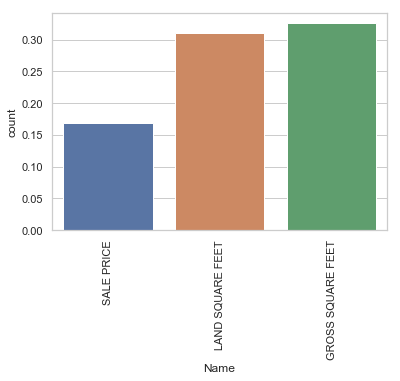

In [20]:
#plot the missing values
sns.set(style='whitegrid',color_codes=True)
sns.barplot(x = "Name", y = "count", data=miss)
plt.xticks(rotation=90)
sns

There are many missing values in the columns :

LAND SQUARE FEET
GROSS SQUARE FEET
SALE PRICE
We can drop the rows with missing values or we can fill them up with their mean, median or any other relation.


Further, We will try to predict the value of SALE PRICE as test data.

In [21]:
# For time being, let's fill these up with mean values.
df["LAND SQUARE FEET"] = df["LAND SQUARE FEET"].fillna(df["LAND SQUARE FEET"].mean())
df["GROSS SQUARE FEET"] = df["GROSS SQUARE FEET"].fillna(df["GROSS SQUARE FEET"].mean())

In [22]:
# Splitting dataset
test = df[df["SALE PRICE"].isna()]
test = test.drop(columns='SALE PRICE')
data = df[~df["SALE PRICE"].isna()]

In [23]:
print(test.shape)
print(data.shape)

(14041, 18)
(69486, 19)


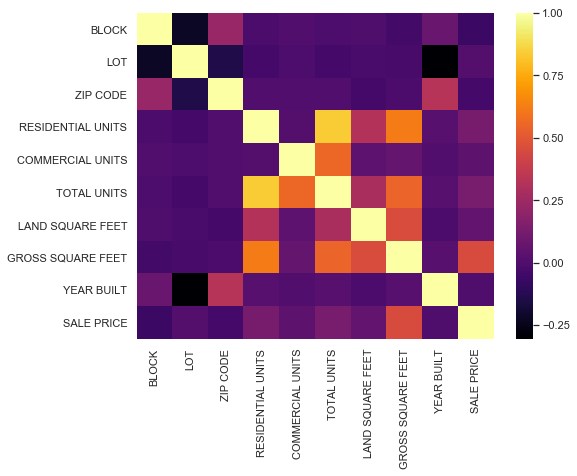

In [24]:
# Correlation between the features
corr = data.corr()
a4_dims = (8,6)
fig, ax = plt.subplots(figsize=a4_dims)
sns.heatmap(corr, cmap = "inferno")

In [25]:
corr["SALE PRICE"].sort_values(ascending = False)

SALE PRICE           1.000000
GROSS SQUARE FEET    0.453035
TOTAL UNITS          0.130028
RESIDENTIAL UNITS    0.127367
LAND SQUARE FEET     0.060101
COMMERCIAL UNITS     0.044536
LOT                  0.012270
YEAR BUILT          -0.003688
ZIP CODE            -0.034139
BLOCK               -0.061320
Name: SALE PRICE, dtype: float64

In [26]:
data.describe()

,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE
count,69486.000000,69486.000000,69486.000000,69486.000000,69486.000000,69486.000000,6.948600e+04,6.948600e+04,69486.000000,6.948600e+04
mean,4201.651110,375.001079,10741.105748,1.854791,0.164105,2.039058,3.632874e+03,3.616215e+03,1799.717439,1.282441e+06
std,3432.581004,656.529496,1265.688362,13.695453,9.005031,16.499349,3.316734e+04,2.405636e+04,520.339082,1.144020e+07
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,1350.000000,22.000000,10306.000000,0.000000,0.000000,0.000000,1.900000e+03,1.268000e+03,1920.000000,2.300000e+05
50%,3380.000000,50.000000,11209.000000,1.000000,0.000000,1.000000,2.945000e+03,2.400000e+03,1938.000000,5.350000e+05
75%,6193.000000,891.750000,11249.000000,2.000000,0.000000,2.000000,3.847516e+03,3.869704e+03,1965.000000,9.500000e+05
max,16319.000000,9106.000000,11694.000000,1844.000000,2261.000000,2261.000000,4.252327e+06,3.750565e+06,2017.000000,2.210000e+09


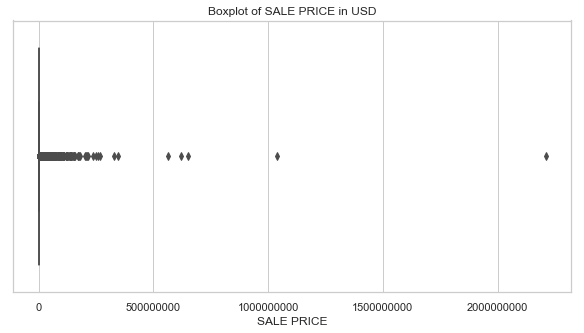

In [27]:
plt.figure(figsize=(10,5))
sns.boxplot(x="SALE PRICE", data=data)
plt.ticklabel_format(style="plain", axis="x")
plt.title('Boxplot of SALE PRICE in USD')
plt.show()

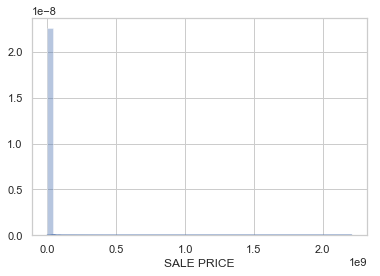

In [28]:
sns.distplot(data["SALE PRICE"])

In [29]:
# Remove observations that fall outside those caps
data = data[((data["SALE PRICE"] >= 100000) & (data["SALE PRICE"] < 5000000))]

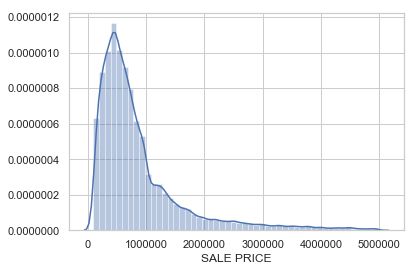

In [30]:
# Check the distribution
sns.distplot(data["SALE PRICE"])

In [31]:
# Check the skewness
data["SALE PRICE"].skew()

2.3426086721835038

0.18219235385333285
Voila, it's notmalized


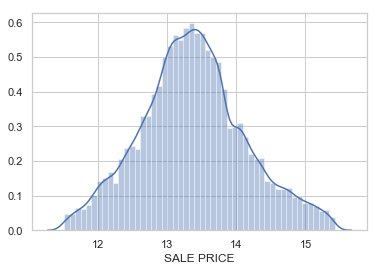

In [32]:
sales = np.log(data["SALE PRICE"])
print(sales.skew())
sns.distplot(sales)
print("Voila, it's notmalized")

In [33]:
data.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'BUILDING CLASS AT PRESENT',
       'ZIP CODE', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALES_MONTH', 'DAY_OF_WEEK'],
      dtype='object')

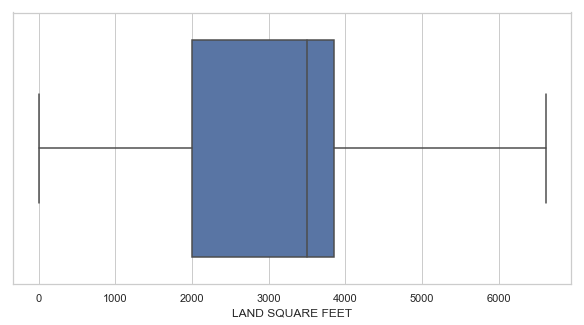

In [34]:
# Lets visualize some variables
plt.figure(figsize=(10,5))
sns.boxplot(x="LAND SQUARE FEET", data=data, showfliers=False)

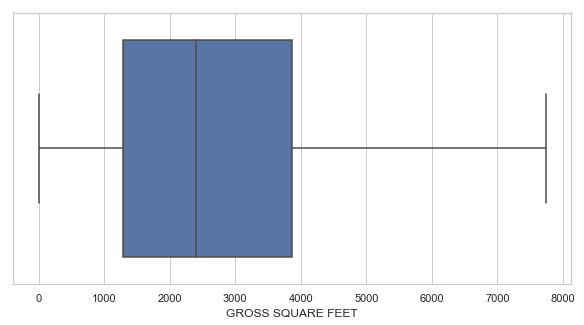

In [35]:
plt.figure(figsize=(10,5))
sns.boxplot(x="GROSS SQUARE FEET", data=data, showfliers=False)

In [36]:
data = data[data["LAND SQUARE FEET"] <= 10000]
data = data[data["GROSS SQUARE FEET"] <= 10000]
data["GROSS SQUARE FEET"].max()

10000.0

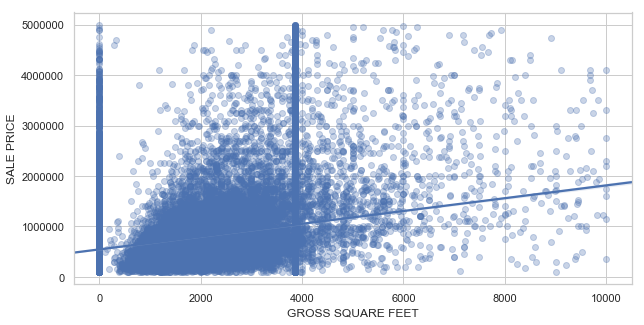

In [37]:
plt.figure(figsize=(10,5))
sns.regplot(x='GROSS SQUARE FEET', y='SALE PRICE', data=data, fit_reg=True, scatter_kws={'alpha':0.3})

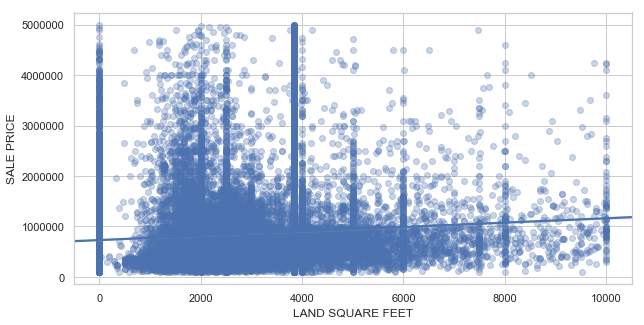

In [38]:
plt.figure(figsize=(10,5))
sns.regplot(x="LAND SQUARE FEET",y="SALE PRICE", data=data, fit_reg=True, scatter_kws={"alpha" :0.3})

### Units

In [39]:
data[["TOTAL UNITS", "SALE PRICE"]].groupby(['TOTAL UNITS'], as_index=False).count()\
.sort_values(by='SALE PRICE', ascending=False)

,TOTAL UNITS,SALE PRICE
1,1,24656
0,0,15484
2,2,9508
3,3,2728
4,4,699
6,6,363
5,5,171
8,8,134
7,7,70
9,9,56


In [40]:
# Remove data that does not make sense
data = data[data["TOTAL UNITS"] != 0]
data = data[data["TOTAL UNITS"] != 2261]

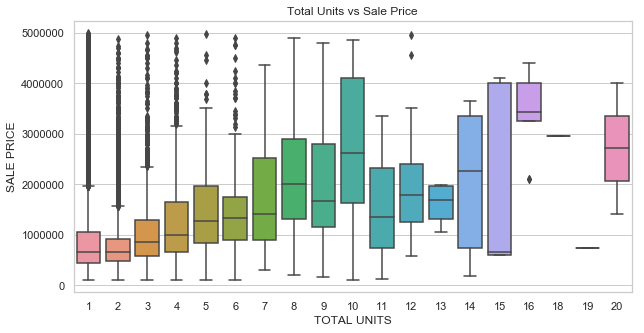

In [41]:
# Visualize the price of different units
plt.figure(figsize=(10,5))
sns.boxplot(x="TOTAL UNITS", y="SALE PRICE", data=data)
plt.title('Total Units vs Sale Price')
plt.show()

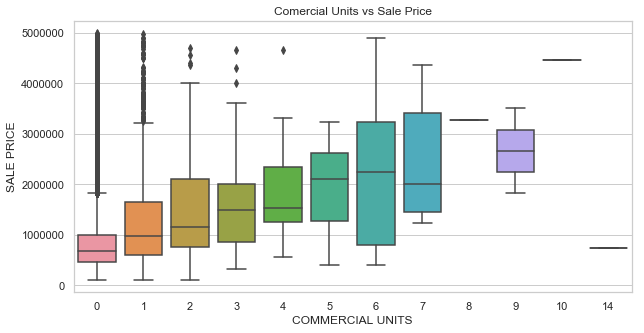

In [42]:
plt.figure(figsize=(10,5))
sns.boxplot(x="COMMERCIAL UNITS", y="SALE PRICE", data=data)
plt.title("Comercial Units vs Sale Price")
plt.show()

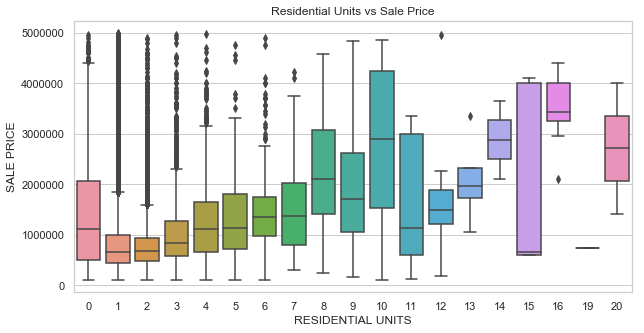

In [43]:
plt.figure(figsize=(10,5))
sns.boxplot(x="RESIDENTIAL UNITS", y="SALE PRICE", data=data)
plt.title("Residential Units vs Sale Price")
plt.show()

In [44]:
# Lets take a look at the categorical data
data.describe(include=["category"])

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BUILDING CLASS AT PRESENT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALES_MONTH,DAY_OF_WEEK
count,38482,38482,38482,38482,38482,38482,38482,38482,38482
unique,5,247,36,9,104,3,104,12,7
top,4,FLUSHING-NORTH,01 ONE FAMILY DWELLINGS,1,R4,1,R4,6,Thursday
freq,12642,1674,12264,24063,8929,25294,8933,3832,8866


### Tax Class

In [45]:
# See the different unique values
data["TAX CLASS AT PRESENT"].unique()

[2B, 2, 2A, 2C, 4, 1C, 1, 1A, 1B]
Categories (9, object): [2B, 2, 2A, 2C, ..., 1C, 1, 1A, 1B]

In [46]:
pivot = data.pivot_table(index="TAX CLASS AT PRESENT", values="SALE PRICE", aggfunc=np.median)
pivot

,SALE PRICE
TAX CLASS AT PRESENT,
1,594000.0
1A,390000.0
1B,640606.5
1C,958668.0
2,979804.5
2A,1200000.0
2B,1847500.0
2C,835000.0
4,1050000.0


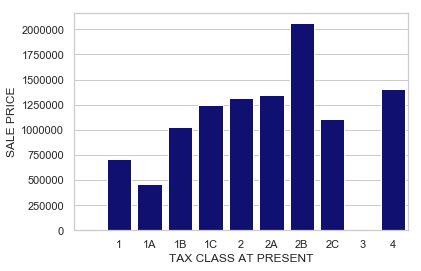

In [47]:
sns.barplot(x="TAX CLASS AT PRESENT", y="SALE PRICE", data=data, ci=None, color="navy")

In [48]:
data["TAX CLASS AT TIME OF SALE"].unique()

[2, 4, 1]
Categories (3, int64): [2, 4, 1]

In [49]:
pivot2 = data.pivot_table(index="TAX CLASS AT TIME OF SALE", values="SALE PRICE"\
                                                      , aggfunc=np.median)
pivot2

,SALE PRICE
TAX CLASS AT TIME OF SALE,
1,582000.0
2,990000.0
4,1050000.0


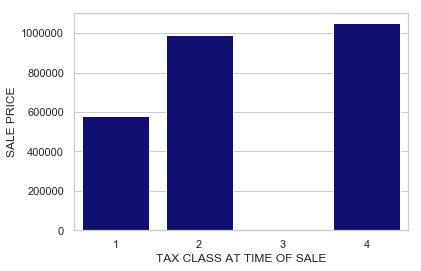

In [50]:
sns.barplot(x="TAX CLASS AT TIME OF SALE", y="SALE PRICE", data=pivot2.reset_index(), color="navy", ci=None)

### BOROUGH

In [51]:
data["BOROUGH"].unique()

[1, 2, 3, 4, 5]
Categories (5, int64): [1, 2, 3, 4, 5]

In [52]:
pivot3 = data.pivot_table(index="BOROUGH", values="SALE PRICE", aggfunc=np.median)
pivot3.sort_values(by="SALE PRICE", ascending=False)

,SALE PRICE
BOROUGH,
1,1435000.0
3,860000.0
4,635000.0
5,470000.0
2,451000.0


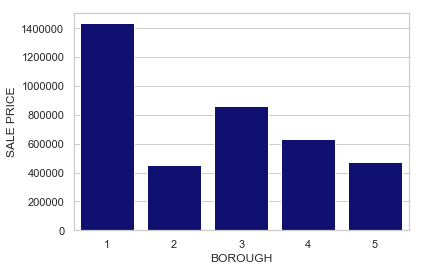

In [53]:
sns.barplot(x="BOROUGH", y="SALE PRICE", data=pivot3.reset_index(), color="navy", ci=None)

This confirms that Manhatten==1 and is the most expensive area.

### BUILDING CLASS CATEGORY

In [54]:
print(data["BUILDING CLASS CATEGORY"].nunique())
pivot4 = data.pivot_table(index="BUILDING CLASS CATEGORY", values="SALE PRICE", aggfunc=np.median)
pivot4.sort_values(by="SALE PRICE", ascending=False)

36


,SALE PRICE
BUILDING CLASS CATEGORY,
08 RENTALS - ELEVATOR APARTMENTS,3670000.0
23 LOFT BUILDINGS,2837500.0
38 ASYLUMS AND HOMES,2674416.0
30 WAREHOUSES,1598545.0
42 CONDO CULTURAL/MEDICAL/EDUCATIONAL/ETC,1536603.5
31 COMMERCIAL VACANT LAND,1501923.0
43 CONDO OFFICE BUILDINGS,1460598.5
27 FACTORIES,1440000.0
26 OTHER HOTELS,1400000.0


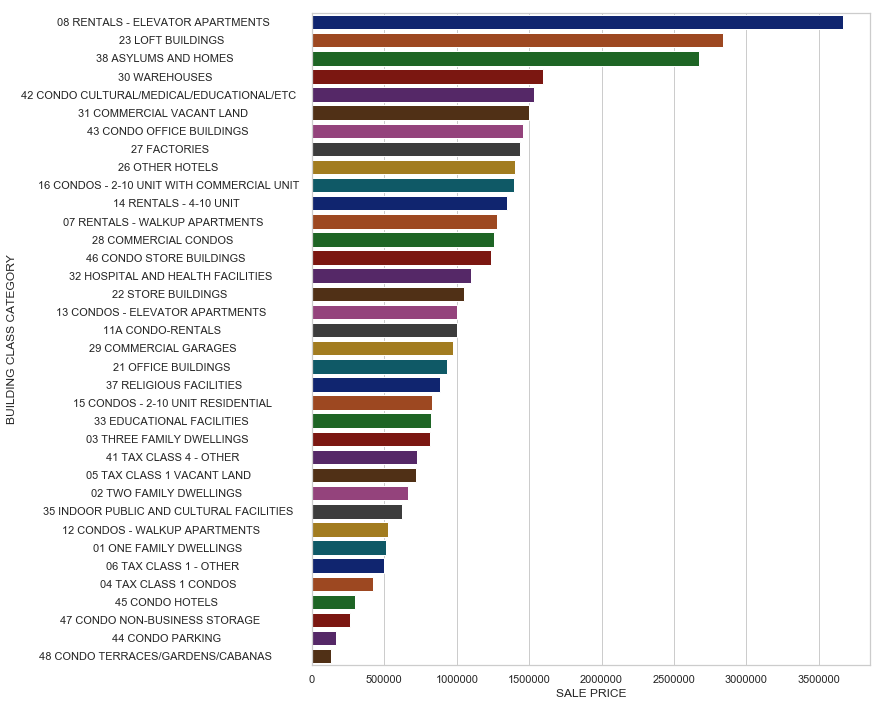

In [55]:
plt.figure(figsize=(10,12))
result = pivot4.groupby(["BUILDING CLASS CATEGORY"])['SALE PRICE'].aggregate(np.median).reset_index().\
sort_values('SALE PRICE', ascending=False)
sns.barplot(x="SALE PRICE", y="BUILDING CLASS CATEGORY", data=pivot4.reset_index(), palette="dark", ci=None,\
           order=result["BUILDING CLASS CATEGORY"])

In [56]:
pivot5 = data.pivot_table(index="NEIGHBORHOOD", values="SALE PRICE", aggfunc=np.median)
pivot5.sort_values(by="SALE PRICE", ascending=False)

,SALE PRICE
NEIGHBORHOOD,
CIVIC CENTER,3232943.5
LITTLE ITALY,2900000.0
BROOKLYN HEIGHTS,2826508.5
SOHO,2600000.0
JAVITS CENTER,2405000.0
FLATIRON,2362500.0
TRIBECA,2232500.0
GREENWICH VILLAGE-CENTRAL,2100000.0
UPPER EAST SIDE (96-110),1965000.0


## 3. Data Pre Processing

In [57]:
# Take a look at our data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38482 entries, 3 to 84545
Data columns (total 19 columns):
BOROUGH                           38482 non-null category
NEIGHBORHOOD                      38482 non-null category
BUILDING CLASS CATEGORY           38482 non-null category
TAX CLASS AT PRESENT              38482 non-null category
BLOCK                             38482 non-null int64
LOT                               38482 non-null int64
BUILDING CLASS AT PRESENT         38482 non-null category
ZIP CODE                          38482 non-null int64
RESIDENTIAL UNITS                 38482 non-null int64
COMMERCIAL UNITS                  38482 non-null int64
TOTAL UNITS                       38482 non-null int64
LAND SQUARE FEET                  38482 non-null float64
GROSS SQUARE FEET                 38482 non-null float64
YEAR BUILT                        38482 non-null int64
TAX CLASS AT TIME OF SALE         38482 non-null category
BUILDING CLASS AT TIME OF SALE    38482 non-

In [58]:
numeric_data=data.select_dtypes(include=[np.number])
numeric_data.columns

Index(['BLOCK', 'LOT', 'ZIP CODE', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS',
       'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'SALE PRICE'],
      dtype='object')

In [59]:
#transform the numeric features using log(x + 1)
from scipy.stats import skew
skewed = data[numeric_data.columns].apply(lambda x: skew(x.dropna().astype(float)))
skewed = skewed[skewed > 0.75]
skewed = skewed.index
data[skewed] = np.log1p(data[skewed])
numeric_data.head()

,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE
3,402,21,10009,10,0,10,2272.000000,6794.000000,1913,3936272.0
6,406,32,10009,8,0,8,1750.000000,4226.000000,1920,3192840.0
76,386,1002,10009,1,0,1,3847.515779,3869.703628,0,620000.0
79,373,1003,10009,1,0,1,3847.515779,3869.703628,1920,762669.0
80,373,1004,10009,1,0,1,3847.515779,3869.703628,1920,772851.0


In [60]:
scaler = StandardScaler()
scaler.fit(data[numeric_data.columns])
scaled = scaler.transform(data[numeric_data.columns])

for i, col in enumerate(numeric_data.columns):
       data[col] = scaled[:,i]

# Check if everythong went as expected
data.describe()

,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE
count,3.848200e+04,3.848200e+04,3.848200e+04,3.848200e+04,3.848200e+04,3.848200e+04,3.848200e+04,3.848200e+04,3.848200e+04,3.848200e+04
mean,3.045973e-15,-1.952953e-15,-5.544472e-14,3.045359e-14,2.251429e-14,-2.615195e-15,1.159069e-14,2.141705e-14,-6.945515e-15,1.480125e-14
std,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00
min,-5.752073e+00,-2.154526e+00,-1.750063e+01,-2.636470e+00,-2.056743e-01,-6.406138e-01,-1.777777e+00,-1.581274e+00,-3.818073e+00,-2.835545e+00
25%,-4.962544e-01,-7.219797e-01,-9.504073e-01,-5.119690e-01,-2.056743e-01,-6.406138e-01,-5.420664e-01,-6.719098e-01,1.911973e-01,-6.419232e-01
50%,2.666221e-01,-3.063615e-01,4.972557e-01,-5.119690e-01,-2.056743e-01,-6.406138e-01,-1.244396e-01,-1.746011e-01,2.329605e-01,-6.820743e-02
75%,6.828050e-01,1.191005e+00,7.315781e-01,7.307845e-01,-2.056743e-01,6.750342e-01,6.688545e-01,1.146819e+00,3.290159e-01,5.658440e-01
max,1.375348e+00,2.358039e+00,1.267631e+00,6.695013e+00,1.514210e+01,6.989099e+00,4.581213e+00,5.523135e+00,3.937489e-01,2.811089e+00


In [61]:
#Dropping few columns
del data['BUILDING CLASS AT PRESENT']
del data['BUILDING CLASS AT TIME OF SALE']

In [62]:
# Lets take a look at the categorical data
data.describe(include=["category"])

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,TAX CLASS AT TIME OF SALE,SALES_MONTH,DAY_OF_WEEK
count,38482,38482,38482,38482,38482,38482,38482
unique,5,247,36,9,3,12,7
top,4,FLUSHING-NORTH,01 ONE FAMILY DWELLINGS,1,1,6,Thursday
freq,12642,1674,12264,24063,25294,3832,8866


In [63]:
# Select the variables to be one-hot encoded
one_hot_features = ['BOROUGH', 'BUILDING CLASS CATEGORY','TAX CLASS AT PRESENT','TAX CLASS AT TIME OF SALE',\
                   'DAY_OF_WEEK','SALES_MONTH',"NEIGHBORHOOD"]

In [64]:
# Convert categorical variables into dummy/indicator variables (i.e. one-hot encoding).
one_hot_encoded = pd.get_dummies(data[one_hot_features])
one_hot_encoded.info(verbose=True, memory_usage=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38482 entries, 3 to 84545
Data columns (total 340 columns):
BOROUGH_1                                                               38482 non-null uint8
BOROUGH_2                                                               38482 non-null uint8
BOROUGH_3                                                               38482 non-null uint8
BOROUGH_4                                                               38482 non-null uint8
BOROUGH_5                                                               38482 non-null uint8
BUILDING CLASS CATEGORY_01 ONE FAMILY DWELLINGS                         38482 non-null uint8
BUILDING CLASS CATEGORY_02 TWO FAMILY DWELLINGS                         38482 non-null uint8
BUILDING CLASS CATEGORY_03 THREE FAMILY DWELLINGS                       38482 non-null uint8
BUILDING CLASS CATEGORY_04 TAX CLASS 1 CONDOS                           38482 non-null uint8
BUILDING CLASS CATEGORY_05 TAX CLASS 1 VACANT LAND   

In [65]:
# Replacing categorical columns with dummies
fdf = data.drop(one_hot_features,axis=1)
fdf = pd.concat([fdf, one_hot_encoded] ,axis=1)

In [66]:
# Create x and y datasets
Y_fdf = fdf['SALE PRICE']
X_fdf = fdf.drop('SALE PRICE', axis=1)

X_fdf.shape , Y_fdf.shape

((38482, 349), (38482,))

In [67]:
# Create the train and test data
X_train ,X_test, Y_train , Y_test = train_test_split(X_fdf , Y_fdf , test_size = 0.3 , random_state =34)

In [68]:
# Training set
X_train.shape , Y_train.shape

((26937, 349), (26937,))

In [69]:
# Test set
X_test.shape, Y_test.shape

((11545, 349), (11545,))

In [70]:
fdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38482 entries, 3 to 84545
Columns: 350 entries, BLOCK to NEIGHBORHOOD_WYCKOFF HEIGHTS
dtypes: float64(10), uint8(340)
memory usage: 17.0 MB


## 4. Modelling

In [71]:
# RMSE
def rmse(y_test,y_pred):
      return np.sqrt(mean_squared_error(y_test,y_pred))

### 4.1. Linear Regression

In [72]:
linreg = LinearRegression()
linreg.fit(X_train, Y_train)
Y_pred_lin = linreg.predict(X_test)
rmse(Y_test, Y_pred_lin)

0.618285808170434

### 4.2. Lasso Regression

In [73]:
alpha=0.00099
lasso_regr=Lasso(alpha=alpha,max_iter=50000)
lasso_regr.fit(X_train, Y_train)
Y_pred_lasso=lasso_regr.predict(X_test)
rmse(Y_test,Y_pred_lasso)

0.6570073187244609

### 4.3. Ridge Regression

In [74]:
ridge = Ridge(alpha=0.01, normalize=True)
ridge.fit(X_train, Y_train)
Y_pred_ridge = ridge.predict(X_test)
rmse(Y_test,Y_pred_ridge)

0.6186076926623364

### 4.4. RandomForrest Regressor

In [75]:
rf_regr = RandomForestRegressor()
rf_regr.fit(X_train, Y_train)
Y_pred_rf = rf_regr.predict(X_test)
rmse(Y_test,Y_pred_rf)

0.5752070484234383

## 5. Conclusion
We can observe from the result above that the RandomForrest Regressor does the best job of predicting the data. 
Hence, we would have to use this in this scenario. However, we would idealy prefered a lower rmse.